Apply XGBoost on a Kaggle Inclass Competition to predict whether a flight will be delayed for more than 15 minutes.


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

In [3]:
url_train = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/flight_delays_train.csv'
url_test = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/flight_delays_test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [3]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [4]:
train['dep_delayed_15min'].value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

Class is imbalanced. If we assume target to be false for all samples, the accuracy would be 0.80956.


# Base Model
Let's train the default XGBoost classifier on the features DepTime and Distance.

In [4]:
X = train[['DepTime', 'Distance']]
y = train['dep_delayed_15min'].apply(lambda x : 1 if x == 'Y' else 0)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state = 17)

In [6]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

prob = xgb_model.predict_proba(X_valid)
prob  # pred_prob returns the probability of each data example being in a given class (first column for y=0, second column for y=1)

array([[0.9599223 , 0.04007771],
       [0.95408607, 0.04591396],
       [0.77874637, 0.22125362],
       ...,
       [0.7167816 , 0.2832184 ],
       [0.86579937, 0.13420062],
       [0.79214346, 0.20785652]], dtype=float32)

In [7]:
pred = xgb_model.predict(X_valid)

ROC AUC Score: 0.6974
Accuracy Score: 0.8145


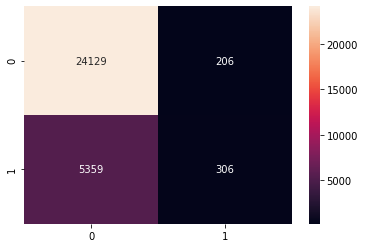

In [8]:
print('ROC AUC Score: {:.4f}'.format(roc_auc_score(y_valid, prob[:, 1])))
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_valid, pred)))
cf_mat = confusion_matrix(y_valid, pred)
sns.heatmap(cf_mat, annot=True,fmt='d')

# Model Optimization
Transform categorical features with One Hot Encoding.

In [6]:
train.Origin.value_counts()

ATL    5834
ORD    4870
DFW    4270
LAX    3259
IAH    3048
       ... 
GST       1
VIS       1
ADK       1
ILG       1
WYS       1
Name: Origin, Length: 289, dtype: int64

In [7]:
train.Dest.value_counts()

ATL    5795
ORD    4933
DFW    4337
LAX    3205
IAH    3056
       ... 
TTN       1
TEX       1
VCT       1
LWB       1
ACK       1
Name: Dest, Length: 289, dtype: int64

There are 289 unique values for Origin and Dest, to avoid overfitting, only keep the top 50 indices.

In [5]:
origin = train.Origin.value_counts().head(50).index.to_list()
train['Origin'] = train.Origin.apply(lambda x: x if x in origin else 'other')

In [6]:
dest = train.Dest.value_counts().head(50).index.to_list()
train['Dest'] = train.Dest.apply(lambda x: x if x in dest else 'other')

In [10]:
len(train.UniqueCarrier.unique())

22

In [11]:
len(test.UniqueCarrier.unique())

20

In [12]:
train.UniqueCarrier.value_counts()

WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: UniqueCarrier, dtype: int64

There are 22 unique values for UniqueCarrier and Dest, keep the top 10 indices.

In [7]:
carrier = train.UniqueCarrier.value_counts().head(10).index.to_list()
train['UniqueCarrier'] = train.UniqueCarrier.apply(lambda x: x if x in carrier else 'other')

In [8]:
onehot_encoder = OneHotEncoder(sparse=False)
encoded_features = pd.DataFrame(onehot_encoder.fit_transform(train[['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']]))
encoded_features.shape

(100000, 163)

In [9]:
X = encoded_features.merge(train[['DepTime', 'Distance']], left_index=True, right_index=True)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state = 17)

In [20]:
xgb_model2 = XGBClassifier()
xgb_model2.fit(X_train, y_train)

prob2 = xgb_model2.predict_proba(X_valid)
pred2 = xgb_model2.predict(X_valid)

ROC AUC Score: 0.7173
Accuracy Score: 0.8173


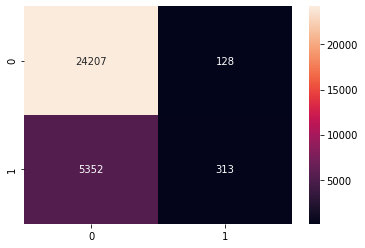

In [21]:
print('ROC AUC Score: {:.4f}'.format(roc_auc_score(y_valid, prob2[:, 1])))
print('Accuracy Score: {:.4f}'.format(accuracy_score(y_valid, pred2)))
cf_mat = confusion_matrix(y_valid, pred2)
sns.heatmap(cf_mat, annot=True, fmt='d')

## Parameters Tuning

In [22]:
parameters = {'n_estimators': range(40, 210, 40),
              'learning_rate': [0.05, 0.1, 0.2]}

gridsearch = GridSearchCV(estimator=XGBClassifier(), 
                          param_grid=parameters,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

gridsearch.fit(X, y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 33.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': range(40, 210, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_

In [23]:
gridsearch.best_estimator_, gridsearch.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.2, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1), 0.7366408386385043)

In [24]:
xgb_model3 = XGBClassifier(n_estimators=200, learning_rate=0.2)

parameters = {'max_depth': range(3, 10, 2),
              'min_child_weight': range(1, 6, 2)}    # if there are fewer than min_child_weight samples at that node, the node becomes a leaf and is no longer split

gridsearch2 = GridSearchCV(estimator=xgb_model3, 
                          param_grid=parameters,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

gridsearch2.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 79.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train

In [25]:
gridsearch2.best_estimator_, gridsearch2.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.2, max_delta_step=0, max_depth=9,
               min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1), 0.7550363122071371)

In [17]:
xgb_model3 = XGBClassifier(n_estimators=200, 
                           learning_rate=0.2, 
                           max_depth=9,
                           min_child_weight=5)

parameters = {'gamma': [i/10 for i in range(6)]}

gridsearch3 = GridSearchCV(estimator=xgb_model3, 
                          param_grid=parameters,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

gridsearch3.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 54.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=9, min_child_weight=5,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verb

In [18]:
gridsearch3.best_estimator_, gridsearch3.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0.3,
               learning_rate=0.2, max_delta_step=0, max_depth=9,
               min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1), 0.7550446006159495)

In [19]:
xgb_model3 = XGBClassifier(n_estimators=200, 
                           learning_rate=0.2, 
                           max_depth=9,
                           min_child_weight=5,
                           gamma=0.3)

parameters = {'subsample': [i/10 for i in range(5,11)],            # fraction of observations to be randomly sampled for each tree
              'colsample_bytree': [i/10 for i in range(5,11)]}     # fraction of columns (features) to be randomly sampled for each tree

gridsearch4 = GridSearchCV(estimator=xgb_model3, 
                          param_grid=parameters,
                          scoring='roc_auc',
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

gridsearch4.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 62.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 314.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0.3,
                                     learning_rate=0.2, max_delta_step=0,
                                     max_depth=9, min_child_weight=5,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             pre_dispatch='2*

In [20]:
gridsearch4.best_estimator_, gridsearch4.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1.0, gamma=0.3,
               learning_rate=0.2, max_delta_step=0, max_depth=9,
               min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1.0, verbosity=1), 0.7550446006159495)

In [10]:
best_model = XGBClassifier(n_estimators=200, 
                           learning_rate=0.2, 
                           max_depth=9,
                           min_child_weight=5,
                           gamma=0.3)

best_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
test['Origin'] = test.Origin.apply(lambda x: x if x in origin else 'other')
test['Dest'] = test.Dest.apply(lambda x: x if x in dest else 'other')
test['UniqueCarrier'] = test.UniqueCarrier.apply(lambda x: x if x in carrier else 'other')
test_encoded_features = pd.DataFrame(onehot_encoder.fit_transform(test[['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest']]))
test_encoded_features.shape

X_test = test_encoded_features.merge(test[['DepTime', 'Distance']], left_index=True, right_index=True)

In [12]:
xgb_test_pred = best_model.predict_proba(X_test)[:, 1]
pd.Series(xgb_test_pred, 
          name='dep_delayed_15min').to_csv('xgb_2feat.csv', 
                                           index_label='id', header=True)